# **DỰ ĐOÁN TÌNH TRẠNG THỜI TIẾT TẠI TP. HỒ CHÍ MINH**

**1. Xác định bối cảnh, yêu cầu**
*(Xem trong slides)*

**2. Thu thập dữ liệu**

- Dữ liệu được lấy từ website https://www.visualcrossing.com/weather-data.

- Dữ liệu là toàn bộ thông tin thời tiết của thành phố Hồ Chí Minh năm 2020 theo giờ.

In [1]:
# Chèn thư viện
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data = pd.read_csv('drive/My Drive/HCMweather2020.csv', delimiter = ',') 

# Đổi tên cột
data.columns = ['Date time', 'Temperature', 'Wind Speed', 'Visibility', 'Cloud Cover', 'Relative Humidity', 'Conditions']

# Hiển thị 5 dòng dữ liệu đầu tiên
data.head()

,Date time,Temperature,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions
0,1/1/2020 0:00,26.0,7.6,10.0,27.0,67.03,Partially cloudy
1,1/1/2020 1:00,25.9,9.4,10.2,25.4,73.53,Partially cloudy
2,1/1/2020 2:00,25.0,10.1,8.0,27.0,71.96,Partially cloudy
3,1/1/2020 3:00,24.6,9.4,8.0,27.0,69.28,Partially cloudy
4,1/1/2020 4:00,23.6,12.2,9.1,32.8,71.34,Partially cloudy


In [3]:
# Xem nhanh cấu trúc bộ dữ liệu
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date time          8784 non-null   object 
 1   Temperature        8778 non-null   float64
 2   Wind Speed         8776 non-null   float64
 3   Visibility         8778 non-null   float64
 4   Cloud Cover        8778 non-null   float64
 5   Relative Humidity  8778 non-null   float64
 6   Conditions         8778 non-null   object 
dtypes: float64(5), object(2)
memory usage: 480.5+ KB


- Bộ dữ liệu gồm 8784 mẫu, gồm 7 thuộc tính (trong đó có 2 thuộc tính không phải số).
- Có một số mẫu thiếu giá trị (giá trị bằng *null*).

Tên các lớp cần phân loại và số lượng + tỉ lệ tương ứng trong bộ dữ dữ liệu:

,Số lượng,Tỉ lệ
Partially cloudy,6802,77.5%
Overcast,1548,17.6%
Clear,219,2.5%
Rain,209,2.4%


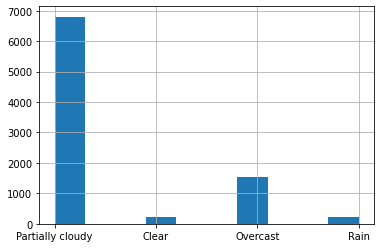

In [4]:
# Vẽ histogram cho thuộc tính Condition
data['Conditions'].hist()

# Tính số lượng và phần trăm số mẫu tương ứng với mỗi nhãn
counts = data['Conditions'].value_counts()
percent100 = data['Conditions'].value_counts(normalize = True).mul(100).round(1).astype(str) + '%'
pd.concat([counts,percent100], axis=1, keys=['Số lượng', 'Tỉ lệ'])

Dựa vào thông tin trên, ta thấy đây là **dữ liệu mất cân bằng** *(imbalanced/skewed data)*. Trong đó lớp *Partially cloudly* chiếm hơn 3/4 số lượng dữ liệu.

**3. CHUẨN BỊ DỮ LIỆU**
- ***Làm sạch dữ liệu:***

In [5]:
# Kiểm tra mẫu thiếu giá trị
print('Cột Date time có thiếu giá trị?', data['Date time'].isnull().values.any())
print('Số lượng thiếu giá trị:', data['Date time'].isnull().sum())
print()

print('Cột Temperature có thiếu giá trị?', data['Temperature'].isnull().values.any())
print('Số lượng thiếu giá trị:', data['Temperature'].isnull().sum())
print()

print('Cột Wind Speed có thiếu giá trị?', data['Wind Speed'].isnull().values.any())
print('Số lượng thiếu giá trị:', data['Wind Speed'].isnull().sum())
print()

print('Cột Visibility có thiếu giá trị?', data['Visibility'].isnull().values.any())
print('Số lượng thiếu giá trị:', data['Visibility'].isnull().sum())
print()

print('Cột Cloud Cover có thiếu giá trị?', data['Cloud Cover'].isnull().values.any())
print('Số lượng thiếu giá trị:', data['Cloud Cover'].isnull().sum())
print()

print('Cột Relative Humidity có thiếu giá trị?', data['Relative Humidity'].isnull().values.any())
print('Số lượng thiếu giá trị:', data['Relative Humidity'].isnull().sum())
print()

print('Cột Relative Humidity có thiếu giá trị?', data['Conditions'].isnull().values.any())
print('Số lượng thiếu giá trị:', data['Conditions'].isnull().sum())
print()

Cột Date time có thiếu giá trị? False
Số lượng thiếu giá trị: 0

Cột Temperature có thiếu giá trị? True
Số lượng thiếu giá trị: 6

Cột Wind Speed có thiếu giá trị? True
Số lượng thiếu giá trị: 8

Cột Visibility có thiếu giá trị? True
Số lượng thiếu giá trị: 6

Cột Cloud Cover có thiếu giá trị? True
Số lượng thiếu giá trị: 6

Cột Relative Humidity có thiếu giá trị? True
Số lượng thiếu giá trị: 6

Cột Relative Humidity có thiếu giá trị? True
Số lượng thiếu giá trị: 6



In [6]:
# Có một số mẫu thiếu giá trị (giá trị bằng null).
# Ta nhận thấy số lượng mẫu thiếu giá trị rất là nhỏ nên
# ta có thể bỏ đi những mẫu dữ liệu thiếu giá trị.
data = data.dropna(subset = ['Conditions'])
data = data.dropna(subset = ['Wind Speed'])

In [7]:
# Kiểm tra lại lần cuối xem bộ dữ liệu còn có mẫu thiếu giá trị hay không?
data.isnull().values.any()

False

- ***Xử lí thuộc tính dạng văn bản và rời rạc:***

In [8]:
# Ta chuyển thuộc tính Conditions từ dạng chuỗi thành số.
condition_encoding = OrdinalEncoder()
encoded_condition = condition_encoding.fit_transform(data[['Conditions']])

data['Conditions'] = encoded_condition

data

,Date time,Temperature,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions
0,1/1/2020 0:00,26.0,7.6,10.0,27.0,67.03,2.0
1,1/1/2020 1:00,25.9,9.4,10.2,25.4,73.53,2.0
2,1/1/2020 2:00,25.0,10.1,8.0,27.0,71.96,2.0
3,1/1/2020 3:00,24.6,9.4,8.0,27.0,69.28,2.0
4,1/1/2020 4:00,23.6,12.2,9.1,32.8,71.34,2.0
...,...,...,...,...,...,...,...
8778,12/31/2020 18:00,28.0,14.8,10.0,50.0,48.08,2.0
8780,12/31/2020 20:00,26.0,16.6,10.0,50.0,54.07,2.0
8781,12/31/2020 21:00,25.0,16.6,10.0,50.0,53.82,2.0
8782,12/31/2020 22:00,25.0,14.8,10.0,50.0,53.82,2.0


In [9]:
# Ta tách thuộc tính Date time thành các thuộc tính Hour, Day, Month, Year.
data['Date time'] = pd.to_datetime(data['Date time'],format='%m/%d/%Y %H:%M')
data['Year']=data['Date time'].dt.year 
data['Month']=data['Date time'].dt.month 
data['Day']=data['Date time'].dt.day
data['Hour']=data['Date time'].dt.hour
data.drop(['Date time'], axis = 1, inplace = True)

- ***Co giãn dữ liệu:*** Vì các dữ liệu số không quá chênh lệch giá trị nên bước này ta bỏ qua.

In [10]:
attributes = ['Month', 'Day', 'Hour', 'Temperature', 'Wind Speed', 'Visibility', 'Cloud Cover', 'Relative Humidity']
scaler = StandardScaler()
data[attributes] = scaler.fit_transform(data[attributes].astype(np.float64))

In [11]:
# Xem tóm tắt các thuộc tính dạng số
data.describe()

,Temperature,Wind Speed,Visibility,Cloud Cover,Relative Humidity,Conditions,Year,Month,Day,Hour
count,8.776000e+03,8.776000e+03,8.776000e+03,8.776000e+03,8.776000e+03,8776.000000,8776.0,8.776000e+03,8.776000e+03,8.776000e+03
mean,-1.835107e-16,9.297485e-16,-1.313561e-14,1.065563e-15,-7.495777e-16,1.797630,2020.0,1.879389e-14,1.032295e-16,-8.503782e-17
std,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,1.000057e+00,0.508905,0.0,1.000057e+00,1.000057e+00,1.000057e+00
min,-2.396508e+00,-1.810753e+00,-5.848532e+00,-2.378694e+00,-3.313702e+00,0.000000,2020.0,-1.596793e+00,-1.674191e+00,-1.661862e+00
25%,-8.501025e-01,-7.597729e-01,-4.706134e-01,-7.841311e-01,-7.420838e-01,2.000000,2020.0,-7.274719e-01,-8.795860e-01,-7.949411e-01
50%,-1.777522e-01,-9.804480e-02,3.567586e-01,-1.136900e-01,2.022451e-01,2.000000,2020.0,1.418491e-01,2.853397e-02,7.198000e-02
75%,6.963032e-01,7.193840e-01,3.567586e-01,6.247012e-01,7.800235e-01,2.000000,2020.0,1.011170e+00,8.231389e-01,8.305360e-01
max,3.049529e+00,5.487719e+00,7.251526e+00,2.151314e+00,1.418029e+00,3.000000,2020.0,1.590717e+00,1.731259e+00,1.661335e+00


In [12]:
# Chia tập dữ liệu ban đầu thành các tập train, test theo tỉ lệ 80:20
X = data[['Month', 'Day', 'Hour', 'Temperature', 'Wind Speed', 'Visibility', 'Cloud Cover', 'Relative Humidity']]
y = data['Conditions']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

In [13]:
print('Số lượng mẫu trong tập train:', len(X_train))
print('Số lượng mẫu trong tập test:', len(X_test))

Số lượng mẫu trong tập train: 7020
Số lượng mẫu trong tập test: 1756


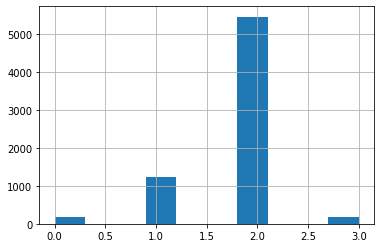

In [14]:
# Vẽ histogram cho thuộc tính Conditions trên tập train
y_train.hist()

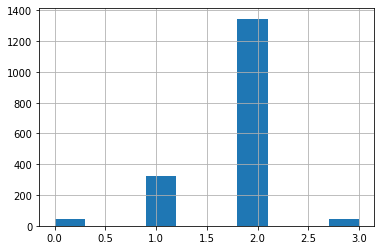

In [15]:
# Vẽ histogram cho thuộc tính Conditions trên tập test
y_test.hist()

**TRỰC QUAN HÓA DỮ LIỆU**

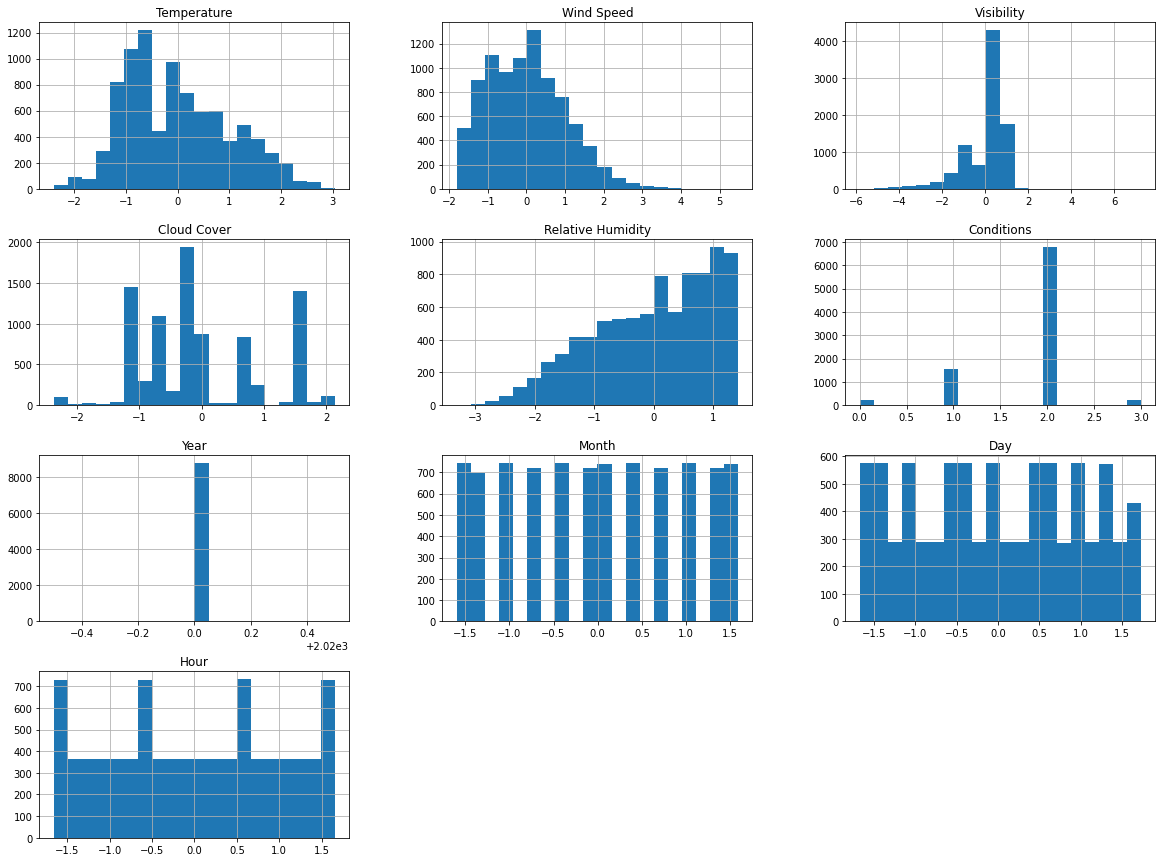

In [16]:
# Vẽ histogram cho mỗi thuộc tính
data.hist(bins=20, figsize=(20, 15))
plt.show()

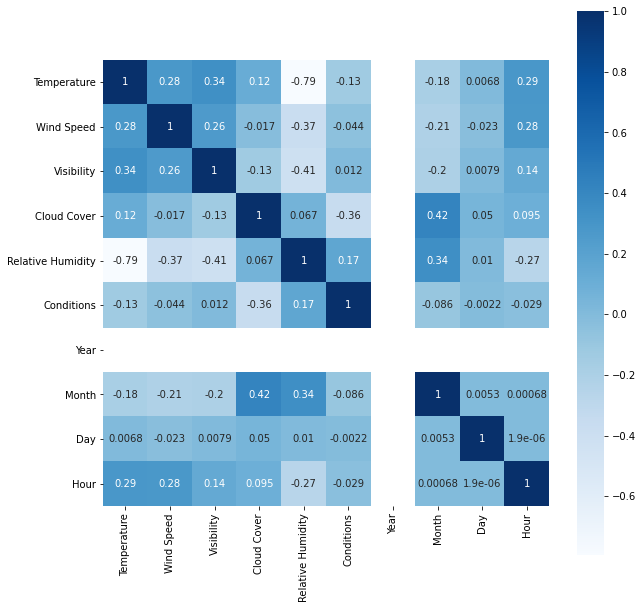

In [17]:
# Vẽ ma trận tương quan giữa thuộc tính Conditions với các thuộc tính còn lại
correlation = data.corr()
fig = plt.subplots(figsize = (10,10))
sn.heatmap(correlation, vmax=1, square = True, annot = True, cmap = 'Blues')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 2020.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 2020.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 2020.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc36d782390>,
      dtype=object)

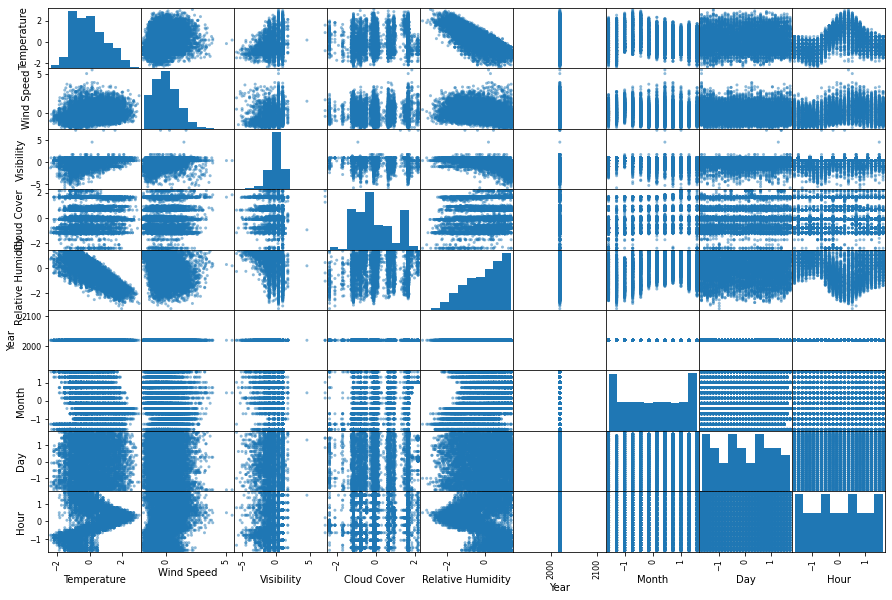

In [18]:
# Vẽ ma trận phân tán cho các thuộc tính
scatter_matrix(data.drop(['Conditions'], axis = 1, inplace = False), figsize=(15, 10))

**HUẤN LUYỆN MÔ HÌNH VÀ TINH CHỈNH SIÊU THAM SỐ**

**1. Decision Tree**

In [19]:
DT_param_grid = [
        {'criterion': ['gini', 'entropy'],
         'min_samples_split': [2, 5, 10, 15, 20],
         'min_samples_leaf': [1, 5, 10, 15, 20],
         'max_features': [8, 7, 6, 5]},
    ]

DT_clf = DecisionTreeClassifier()
DT_grid_search = GridSearchCV(DT_clf, DT_param_grid, cv=3, scoring='f1_macro', verbose=2)

In [121]:
DT_grid_search.fit(X_train, y_train)
DT_grid_search.best_params_

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=5 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=5, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=5 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=5, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=5 
[CV]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=10, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=15 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=15, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=15 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=15, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=15 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=15, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=20 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=20, total=   0.0s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=20 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=20, total=   0.0s
[CV] criterion=gini, max_features=8, min_

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:   10.8s finished


{'criterion': 'gini',
 'max_features': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [20]:
DT_model = DecisionTreeClassifier(criterion='gini', max_features=7, min_samples_leaf=1, min_samples_split=2)
DT_model = DT_model.fit(X_train, y_train)
y_pred = DT_model.predict(X_test)

In [21]:
DT_precision_macro_test = metrics.precision_score(y_test, y_pred, average='macro')
DT_recall_macro_test = metrics.recall_score(y_test, y_pred, average='macro')
DT_f1_macro_test = metrics.f1_score(y_test, y_pred, average='macro')

DT_precision_weighted_test = metrics.precision_score(y_test, y_pred, average='weighted')
DT_recall_weighted_test = metrics.recall_score(y_test, y_pred, average='weighted')
DT_f1_weighted_test = metrics.f1_score(y_test, y_pred, average='weighted')

**2. Random Forest**

In [22]:
RF_param_grid = [
        {'n_estimators': [5, 10, 20, 50],
         'criterion': ['gini', 'entropy'],
         'min_samples_split': [2, 5, 10],
         'min_samples_leaf': [1, 5, 10],
         'max_features': [8, 7, 6, 5]},
    ]

RF_clf = RandomForestClassifier()
RF_grid_search = GridSearchCV(RF_clf, RF_param_grid, cv=3, scoring='f1_macro', verbose=2)

In [125]:
RF_grid_search.fit(X_train, y_train)
RF_grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=5 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=5, total=   0.1s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=10, total=   0.1s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.2s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  criterion=gini, max_features=8, min_samples_leaf=1, min_samples_split=2, n_estimators=20, total=   0.2s
[CV] criterion=gini, max_features=8, min_samples_leaf=1, min_samples_s

[Parallel(n_jobs=1)]: Done 864 out of 864 | elapsed:  2.9min finished


{'criterion': 'entropy',
 'max_features': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [23]:
RF_model = RandomForestClassifier(criterion='entropy', max_features=8, min_samples_leaf=1, min_samples_split=5, n_estimators=10)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)

In [24]:
RF_precision_macro_test = metrics.precision_score(y_test, y_pred, average='macro')
RF_recall_macro_test = metrics.recall_score(y_test, y_pred, average='macro')
RF_f1_macro_test = metrics.f1_score(y_test, y_pred, average='macro')

RF_precision_weighted_test = metrics.precision_score(y_test, y_pred, average='weighted')
RF_recall_weighted_test = metrics.recall_score(y_test, y_pred, average='weighted')
RF_f1_weighted_test = metrics.f1_score(y_test, y_pred, average='weighted')

**3. SVM**

In [25]:
SVC_param_grid = [
        {'kernel': ['linear'],
         'decision_function_shape': ['ovo', 'ovr'],
         'C': [1, 10, 100],},
        {'kernel': ['poly', 'rbf'],
         'decision_function_shape': ['ovo', 'ovr'],
         'C': [1, 10, 100],
         'gamma': [0.1, 0.01, 0.001]},
    ]

SVC_clf = SVC()
SVC_grid_search = GridSearchCV(SVC_clf, SVC_param_grid, cv=3, scoring='f1_macro', verbose=2)

In [26]:
SVC_grid_search.fit(X_train, y_train)
SVC_grid_search.best_params_

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV] C=1, decision_function_shape=ovo, kernel=linear .................
[CV] .. C=1, decision_function_shape=ovo, kernel=linear, total=   0.1s
[CV] C=1, decision_function_shape=ovo, kernel=linear .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .. C=1, decision_function_shape=ovo, kernel=linear, total=   0.1s
[CV] C=1, decision_function_shape=ovo, kernel=linear .................
[CV] .. C=1, decision_function_shape=ovo, kernel=linear, total=   0.1s
[CV] C=1, decision_function_shape=ovr, kernel=linear .................
[CV] .. C=1, decision_function_shape=ovr, kernel=linear, total=   0.1s
[CV] C=1, decision_function_shape=ovr, kernel=linear .................
[CV] .. C=1, decision_function_shape=ovr, kernel=linear, total=   0.1s
[CV] C=1, decision_function_shape=ovr, kernel=linear .................
[CV] .. C=1, decision_function_shape=ovr, kernel=linear, total=   0.1s
[CV] C=10, decision_function_shape=ovo, kernel=linear ................
[CV] . C=10, decision_function_shape=ovo, kernel=linear, total=   0.2s
[CV] C=10, decision_function_shape=ovo, kernel=linear ................
[CV] . C=10, decision_function_shape=ovo, kernel=linear, total=   0.2s
[CV] C=10, decision_function_shape=ovo, kernel=linear ................
[CV] .

[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:  1.0min finished


{'C': 100, 'decision_function_shape': 'ovo', 'kernel': 'linear'}

In [27]:
SVC_model = SVC(kernel='linear', C=100, decision_function_shape='ovo')
SVC_model.fit(X_train, y_train)
y_pred = SVC_model.predict(X_test)

In [28]:
SVC_precision_macro_test = metrics.precision_score(y_test, y_pred, average='macro')
SVC_recall_macro_test = metrics.recall_score(y_test, y_pred, average='macro')
SVC_f1_macro_test = metrics.f1_score(y_test, y_pred, average='macro')

SVC_precision_weighted_test = metrics.precision_score(y_test, y_pred, average='weighted')
SVC_recall_weighted_test = metrics.recall_score(y_test, y_pred, average='weighted')
SVC_f1_weighted_test = metrics.f1_score(y_test, y_pred, average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**4. kNN**

In [29]:
kNN_param_grid = [
        {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
         'weights': ['uniform', 'distance'],
         'leaf_size': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
         'p': [1, 2]},
    ]

kNN_clf = KNeighborsClassifier()
kNN_grid_search = GridSearchCV(kNN_clf, kNN_param_grid, cv=3, scoring='f1_macro', verbose=2)

In [30]:
kNN_grid_search.fit(X_train, y_train)
kNN_grid_search.best_params_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
[CV] leaf_size=5, n_neighbors=2, p=1, weights=uniform ................
[CV] . leaf_size=5, n_neighbors=2, p=1, weights=uniform, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=1, weights=uniform ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] . leaf_size=5, n_neighbors=2, p=1, weights=uniform, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=1, weights=uniform ................
[CV] . leaf_size=5, n_neighbors=2, p=1, weights=uniform, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=1, weights=distance ...............
[CV]  leaf_size=5, n_neighbors=2, p=1, weights=distance, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=1, weights=distance ...............
[CV]  leaf_size=5, n_neighbors=2, p=1, weights=distance, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=1, weights=distance ...............
[CV]  leaf_size=5, n_neighbors=2, p=1, weights=distance, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=2, weights=uniform ................
[CV] . leaf_size=5, n_neighbors=2, p=2, weights=uniform, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=2, weights=uniform ................
[CV] . leaf_size=5, n_neighbors=2, p=2, weights=uniform, total=   0.2s
[CV] leaf_size=5, n_neighbors=2, p=2, weights=uniform ................
[CV] .

[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  2.9min finished


{'leaf_size': 5, 'n_neighbors': 2, 'p': 2, 'weights': 'distance'}

In [31]:
kNN_model = KNeighborsClassifier(leaf_size=5, n_neighbors=2, p=2, weights='distance')
kNN_model.fit(X_train, y_train)
y_pred = kNN_model.predict(X_test)

In [32]:
kNN_precision_macro_test = metrics.precision_score(y_test, y_pred, average='macro')
kNN_recall_macro_test = metrics.recall_score(y_test, y_pred, average='macro')
kNN_f1_macro_test = metrics.f1_score(y_test, y_pred, average='macro')

kNN_precision_weighted_test = metrics.precision_score(y_test, y_pred, average='weighted')
kNN_recall_weighted_test = metrics.recall_score(y_test, y_pred, average='weighted')
kNN_f1_weighted_test = metrics.f1_score(y_test, y_pred, average='weighted')

**5. Logistic Regression**

In [33]:
LR_param_grid = [
        {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
         'C': [0.1, 1, 10, 100, 1000, 10000]},
    ]

LR_clf = LogisticRegression()
LR_grid_search = GridSearchCV(LR_clf, LR_param_grid, cv=3, scoring='f1_macro', verbose=2)

In [34]:
LR_grid_search.fit(X_train, y_train)
LR_grid_search.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] C=0.1, solver=newton-cg .........................................
[CV] .......................... C=0.1, solver=newton-cg, total=   0.1s
[CV] C=0.1, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......................... C=0.1, solver=newton-cg, total=   0.2s
[CV] C=0.1, solver=newton-cg .........................................
[CV] .......................... C=0.1, solver=newton-cg, total=   0.1s
[CV] C=0.1, solver=lbfgs .............................................
[CV] .............................. C=0.1, solver=lbfgs, total=   0.1s
[CV] C=0.1, solver=lbfgs .............................................
[CV] .............................. C=0.1, solver=lbfgs, total=   0.1s
[CV] C=0.1, solver=lbfgs .............................................
[CV] .............................. C=0.1, solver=lbfgs, total=   0.1s
[CV] C=0.1, solver=sag ...............................................
[CV] ................................ C=0.1, solver=sag, total=   0.0s
[CV] C=0.1, solver=sag ...............................................
[CV] ................................ C=0.1, solver=sag, total=   0.0s
[CV] C=0.1, solver=sag ...............................................
[CV] .

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................. C=1, solver=saga, total=   0.2s
[CV] C=1, solver=saga ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................. C=1, solver=saga, total=   0.2s
[CV] C=1, solver=saga ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................. C=1, solver=saga, total=   0.2s
[CV] C=10, solver=newton-cg ..........................................
[CV] ........................... C=10, solver=newton-cg, total=   0.2s
[CV] C=10, solver=newton-cg ..........................................
[CV] ........................... C=10, solver=newton-cg, total=   0.2s
[CV] C=10, solver=newton-cg ..........................................
[CV] ........................... C=10, solver=newton-cg, total=   0.2s
[CV] C=10, solver=lbfgs ..............................................
[CV] ............................... C=10, solver=lbfgs, total=   0.2s
[CV] C=10, solver=lbfgs ..............................................
[CV] ............................... C=10, solver=lbfgs, total=   0.2s
[CV] C=10, solver=lbfgs ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................... C=10, solver=lbfgs, total=   0.2s
[CV] C=10, solver=sag ................................................
[CV] ................................. C=10, solver=sag, total=   0.2s
[CV] C=10, solver=sag ................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................. C=10, solver=sag, total=   0.2s
[CV] C=10, solver=sag ................................................
[CV] ................................. C=10, solver=sag, total=   0.2s
[CV] C=10, solver=saga ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................ C=10, solver=saga, total=   0.2s
[CV] C=10, solver=saga ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................ C=10, solver=saga, total=   0.2s
[CV] C=10, solver=saga ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................ C=10, solver=saga, total=   0.2s
[CV] C=100, solver=newton-cg .........................................
[CV] .......................... C=100, solver=newton-cg, total=   0.4s
[CV] C=100, solver=newton-cg .........................................
[CV] .......................... C=100, solver=newton-cg, total=   0.3s
[CV] C=100, solver=newton-cg .........................................
[CV] .......................... C=100, solver=newton-cg, total=   0.3s
[CV] C=100, solver=lbfgs .............................................
[CV] .............................. C=100, solver=lbfgs, total=   0.2s
[CV] C=100, solver=lbfgs .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................. C=100, solver=lbfgs, total=   0.2s
[CV] C=100, solver=lbfgs .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................. C=100, solver=lbfgs, total=   0.2s
[CV] C=100, solver=sag ...............................................
[CV] ................................ C=100, solver=sag, total=   0.2s
[CV] C=100, solver=sag ...............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ................................ C=100, solver=sag, total=   0.2s
[CV] C=100, solver=sag ...............................................
[CV] ................................ C=100, solver=sag, total=   0.2s
[CV] C=100, solver=saga ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................... C=100, solver=saga, total=   0.2s
[CV] C=100, solver=saga ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................... C=100, solver=saga, total=   0.2s
[CV] C=100, solver=saga ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................... C=100, solver=saga, total=   0.2s
[CV] C=1000, solver=newton-cg ........................................
[CV] ......................... C=1000, solver=newton-cg, total=   0.5s
[CV] C=1000, solver=newton-cg ........................................
[CV] ......................... C=1000, solver=newton-cg, total=   0.6s
[CV] C=1000, solver=newton-cg ........................................
[CV] ......................... C=1000, solver=newton-cg, total=   0.5s
[CV] C=1000, solver=lbfgs ............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................. C=1000, solver=lbfgs, total=   0.2s
[CV] C=1000, solver=lbfgs ............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................. C=1000, solver=lbfgs, total=   0.2s
[CV] C=1000, solver=lbfgs ............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=1000, solver=lbfgs, total=   0.2s
[CV] C=1000, solver=sag ..............................................
[CV] ............................... C=1000, solver=sag, total=   0.2s
[CV] C=1000, solver=sag ..............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................... C=1000, solver=sag, total=   0.2s
[CV] C=1000, solver=sag ..............................................
[CV] ............................... C=1000, solver=sag, total=   0.2s
[CV] C=1000, solver=saga .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................. C=1000, solver=saga, total=   0.2s
[CV] C=1000, solver=saga .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................. C=1000, solver=saga, total=   0.2s
[CV] C=1000, solver=saga .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................. C=1000, solver=saga, total=   0.2s
[CV] C=10000, solver=newton-cg .......................................
[CV] ........................ C=10000, solver=newton-cg, total=   0.6s
[CV] C=10000, solver=newton-cg .......................................
[CV] ........................ C=10000, solver=newton-cg, total=   0.6s
[CV] C=10000, solver=newton-cg .......................................
[CV] ........................ C=10000, solver=newton-cg, total=   0.7s
[CV] C=10000, solver=lbfgs ...........................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................ C=10000, solver=lbfgs, total=   0.2s
[CV] C=10000, solver=lbfgs ...........................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] ............................ C=10000, solver=lbfgs, total=   0.2s
[CV] C=10000, solver=lbfgs ...........................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................ C=10000, solver=lbfgs, total=   0.2s
[CV] C=10000, solver=sag .............................................
[CV] .............................. C=10000, solver=sag, total=   0.2s
[CV] C=10000, solver=sag .............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] .............................. C=10000, solver=sag, total=   0.2s
[CV] C=10000, solver=sag .............................................
[CV] .............................. C=10000, solver=sag, total=   0.2s
[CV] C=10000, solver=saga ............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=10000, solver=saga, total=   0.2s
[CV] C=10000, solver=saga ............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[CV] ............................. C=10000, solver=saga, total=   0.2s
[CV] C=10000, solver=saga ............................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   15.9s finished


[CV] ............................. C=10000, solver=saga, total=   0.2s


{'C': 10000, 'solver': 'newton-cg'}

In [35]:
LR_model = LogisticRegression(C=10000, solver='newton-cg')
LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

In [36]:
LR_precision_macro_test = metrics.precision_score(y_test, y_pred, average='macro')
LR_recall_macro_test = metrics.recall_score(y_test, y_pred, average='macro')
LR_f1_macro_test = metrics.f1_score(y_test, y_pred, average='macro')

LR_precision_weighted_test = metrics.precision_score(y_test, y_pred, average='weighted')
LR_recall_weighted_test = metrics.recall_score(y_test, y_pred, average='weighted')
LR_f1_weighted_test = metrics.f1_score(y_test, y_pred, average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Kết quả sau khi tinh chỉnh tham số và huấn luyện mô hình được trình bày ở bảng sau:

In [37]:
result = pd.DataFrame(data = {'P (macro)': [DT_precision_macro_test, RF_precision_macro_test, SVC_precision_macro_test,
                                            kNN_precision_macro_test, LR_precision_macro_test],
                              'R (macro)': [DT_recall_macro_test, RF_recall_macro_test, SVC_recall_macro_test,
                                            kNN_recall_macro_test, LR_recall_macro_test],
                              'F1 (macro)': [DT_f1_macro_test, RF_f1_macro_test, SVC_f1_macro_test,
                                             kNN_f1_macro_test, LR_f1_macro_test],
                              'P (weighted)': [DT_precision_weighted_test, RF_precision_weighted_test, SVC_precision_weighted_test,
                                            kNN_precision_weighted_test, LR_precision_weighted_test],
                              'R (weighted)': [DT_recall_weighted_test, RF_recall_weighted_test, SVC_recall_weighted_test,
                                            kNN_recall_weighted_test, LR_recall_weighted_test],
                              'F1 (weighted)': [DT_f1_weighted_test, RF_f1_weighted_test, SVC_f1_weighted_test,
                                             kNN_f1_weighted_test, LR_f1_weighted_test],},
                              index = ['Decision Tree', 'Random Forest', 'SVM', 'k-nearest Neighbor', 'Logistic Regression'])

display(result.round(4))

,P (macro),R (macro),F1 (macro),P (weighted),R (weighted),F1 (weighted)
Decision Tree,0.8521,0.8960,0.8697,0.9783,0.9727,0.9751
Random Forest,0.9271,0.8882,0.9044,0.9839,0.9852,0.9842
SVM,0.7297,0.7385,0.7339,0.9522,0.9749,0.9634
k-nearest Neighbor,0.6992,0.6722,0.6839,0.9358,0.9351,0.9352
Logistic Regression,0.7303,0.7498,0.7399,0.9533,0.9761,0.9646
